In [ ]:
# !pip install -c pip -forge xgboost=1.3.3
# !pip install -c pip -forge lightgbm=3.1.1 
# !pip install -c pip -forge missingno=0.4.2

### 1. 필요한 라이브러리 import 하기

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

### 2.데이터살펴보기

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/Github/Kaggle/kaggle_kakr_housing/data/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Github/Kaggle/kaggle_kakr_housing/data/test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print("train.csv. Shape: ",df_train.shape)
print("test.csv. Shape: ",df_test.shape)

train.csv. Shape:  (15035, 21)
test.csv. Shape:  (6468, 20)


1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

### 3.데이터불러오기

In [ ]:
df_train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [ ]:
df_train['price'].describe()

count    1.503500e+04
mean     5.406827e+05
std      3.715247e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

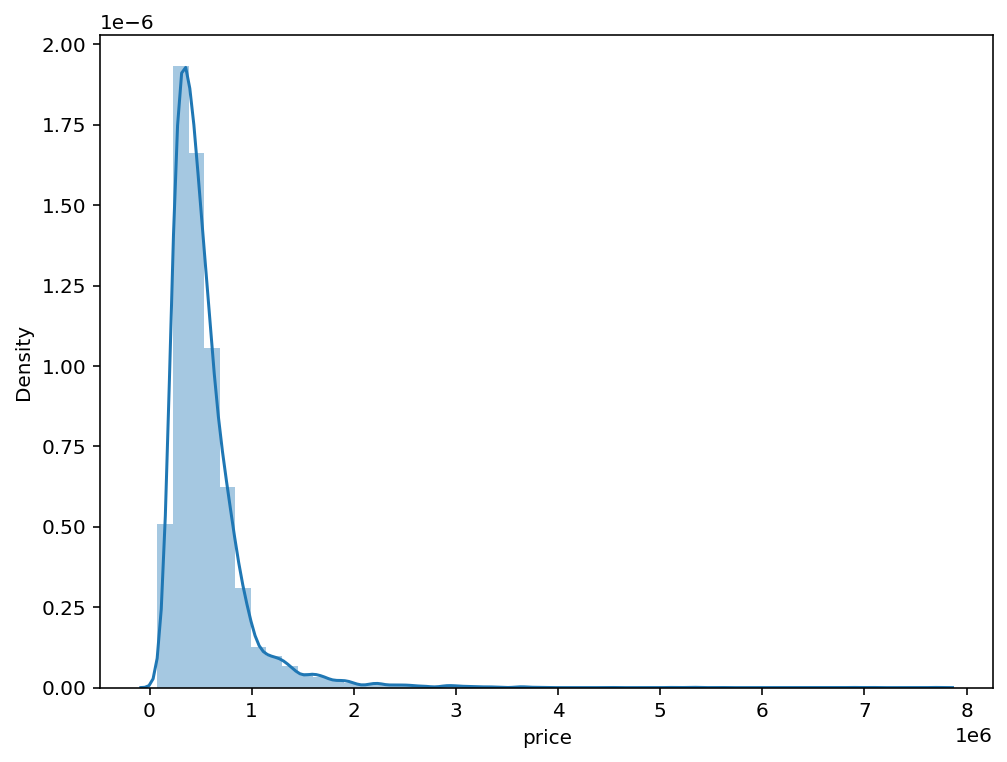

In [ ]:
#histogram
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(df_train['price'])

In [ ]:
#skewness and kurtosis
print("Skewness: %f" % df_train['price'].skew())
print("Kurtosis: %f" % df_train['price'].kurt())

Skewness: 4.290252
Kurtosis: 40.154919


Kurtosis 값이 3에 가까울 수록 정규분포를 따르는데, 값이 40인 것으로 봐서 정규화가 필요한 것으로 판단

-> log 를 취하여 정규화하자!

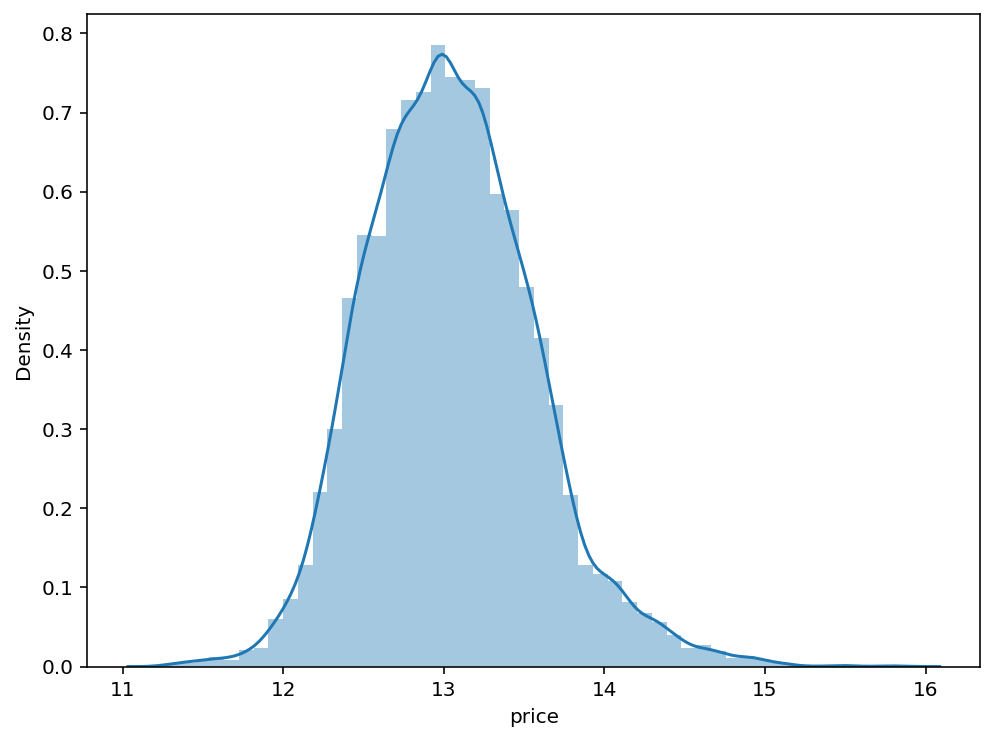

In [ ]:
df_train['price'] = np.log1p(df_train['price'])
#histogram
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(df_train['price'])

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view']


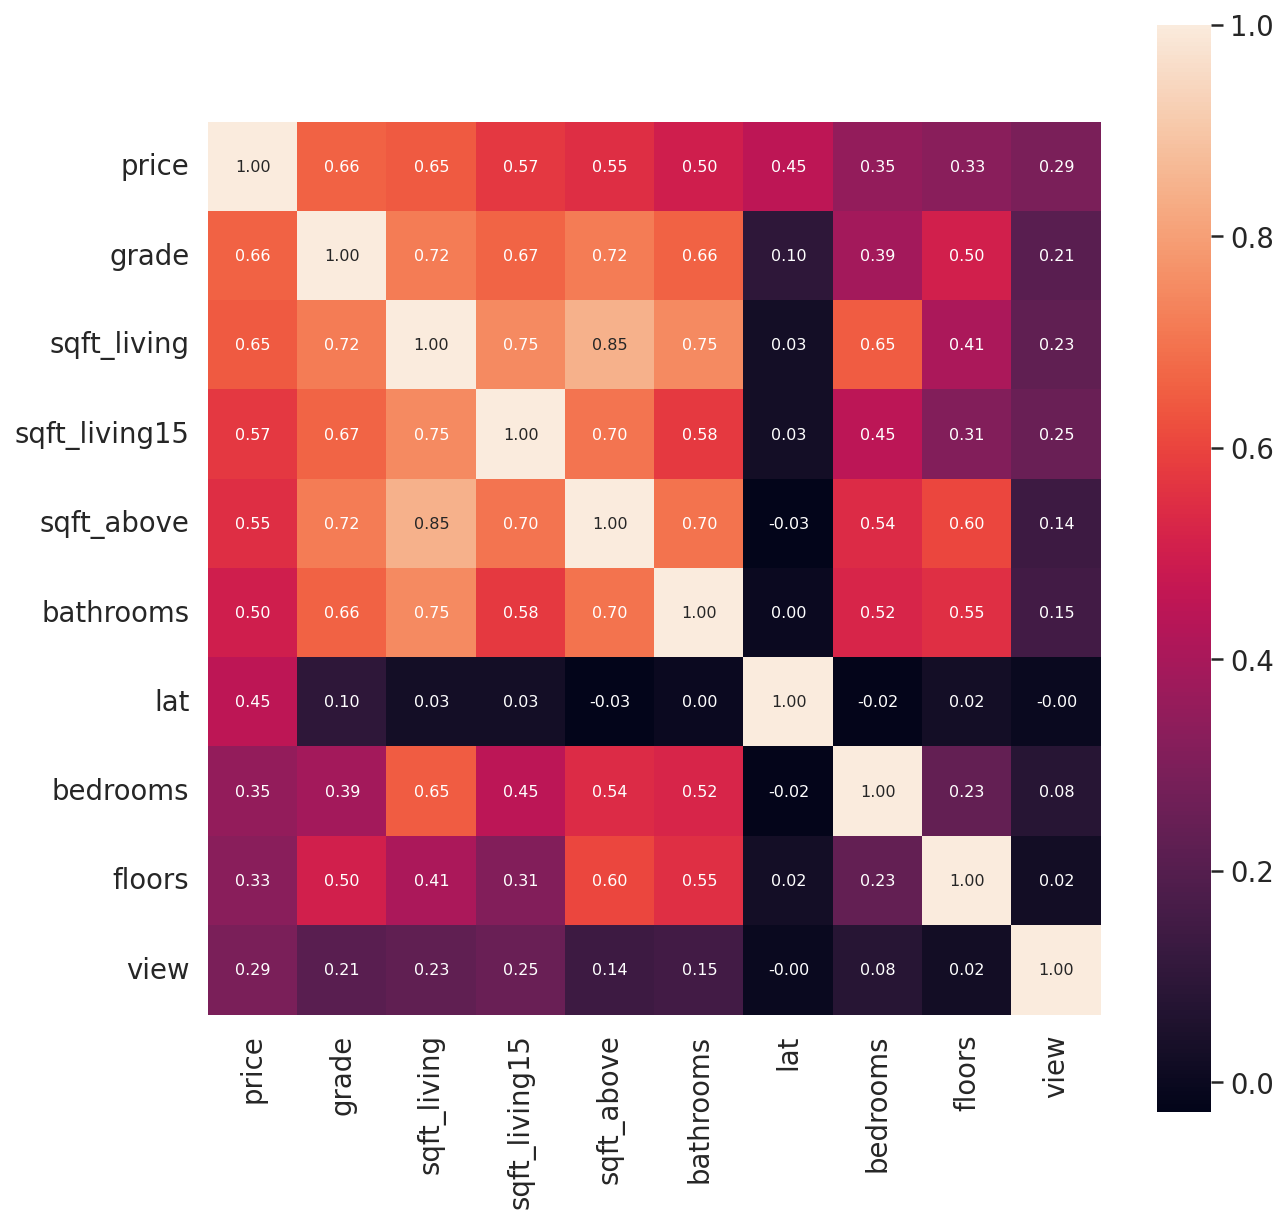

In [ ]:
#상관관계 분석
import scipy as sp

cor_abs = abs(df_train.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=10, columns='price').index # price과 correlation이 높은 column 10개 뽑기(내림차순)
# spearman coefficient matrix
cor = np.array(sp.stats.spearmanr(df_train[cor_cols].values))[0] # 10 x 10
print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values)

In [ ]:
df_train.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.000000,0.035940,0.010520,0.104030,0.041725,-0.034077,0.182848,-0.011775,-0.024360,-0.101618,0.078622,0.073086,-0.050634,0.202477,-0.029810,-0.005761,0.002588,0.014757,0.029248,-0.032269
price,0.035940,1.000000,0.359946,0.552000,0.697907,0.108946,0.317810,0.172580,0.347506,0.042947,0.707412,0.607197,0.314378,0.076293,0.127533,-0.039195,0.444417,0.054362,0.621800,0.096976
bedrooms,0.010520,0.359946,1.000000,0.530548,0.596974,0.033475,0.189532,-0.004819,0.085703,0.034885,0.375286,0.494867,0.315183,0.158799,0.022729,-0.162081,-0.011190,0.135802,0.407394,0.027242
bathrooms,0.104030,0.552000,0.530548,1.000000,0.755853,0.089308,0.508649,0.075452,0.187488,-0.125907,0.666278,0.688255,0.282642,0.503964,0.065423,-0.207500,0.018110,0.227669,0.573541,0.088120
sqft_living,0.041725,0.697907,0.596974,0.755853,1.000000,0.176500,0.363193,0.108137,0.282821,-0.054213,0.762543,0.878736,0.434017,0.315927,0.064893,-0.200745,0.051609,0.245429,0.760271,0.184176
sqft_lot,-0.034077,0.108946,0.033475,0.089308,0.176500,1.000000,0.001535,0.025584,0.080441,-0.002099,0.119906,0.186242,0.017818,0.058686,-0.001451,-0.127709,-0.082234,0.227451,0.147562,0.728458
floors,0.182848,0.317810,0.189532,0.508649,0.363193,0.001535,1.000000,0.031159,0.034511,-0.261016,0.462598,0.529476,-0.239350,0.490436,0.009752,-0.059107,0.049004,0.126983,0.287125,-0.010287
waterfront,-0.011775,0.172580,-0.004819,0.075452,0.108137,0.025584,0.031159,1.000000,0.389669,0.011613,0.088061,0.081968,0.071576,-0.026523,0.104168,0.028632,-0.014772,-0.037922,0.091810,0.028255
view,-0.024360,0.347506,0.085703,0.187488,0.282821,0.080441,0.034511,0.389669,1.000000,0.045255,0.247924,0.172693,0.265880,-0.061670,0.107605,0.089247,0.005285,-0.073151,0.278267,0.076501
condition,-0.101618,0.042947,0.034885,-0.125907,-0.054213,-0.002099,-0.261016,0.011613,0.045255,1.000000,-0.143599,-0.152856,0.175064,-0.366590,-0.062342,0.001106,-0.015974,-0.110742,-0.091407,-0.003873


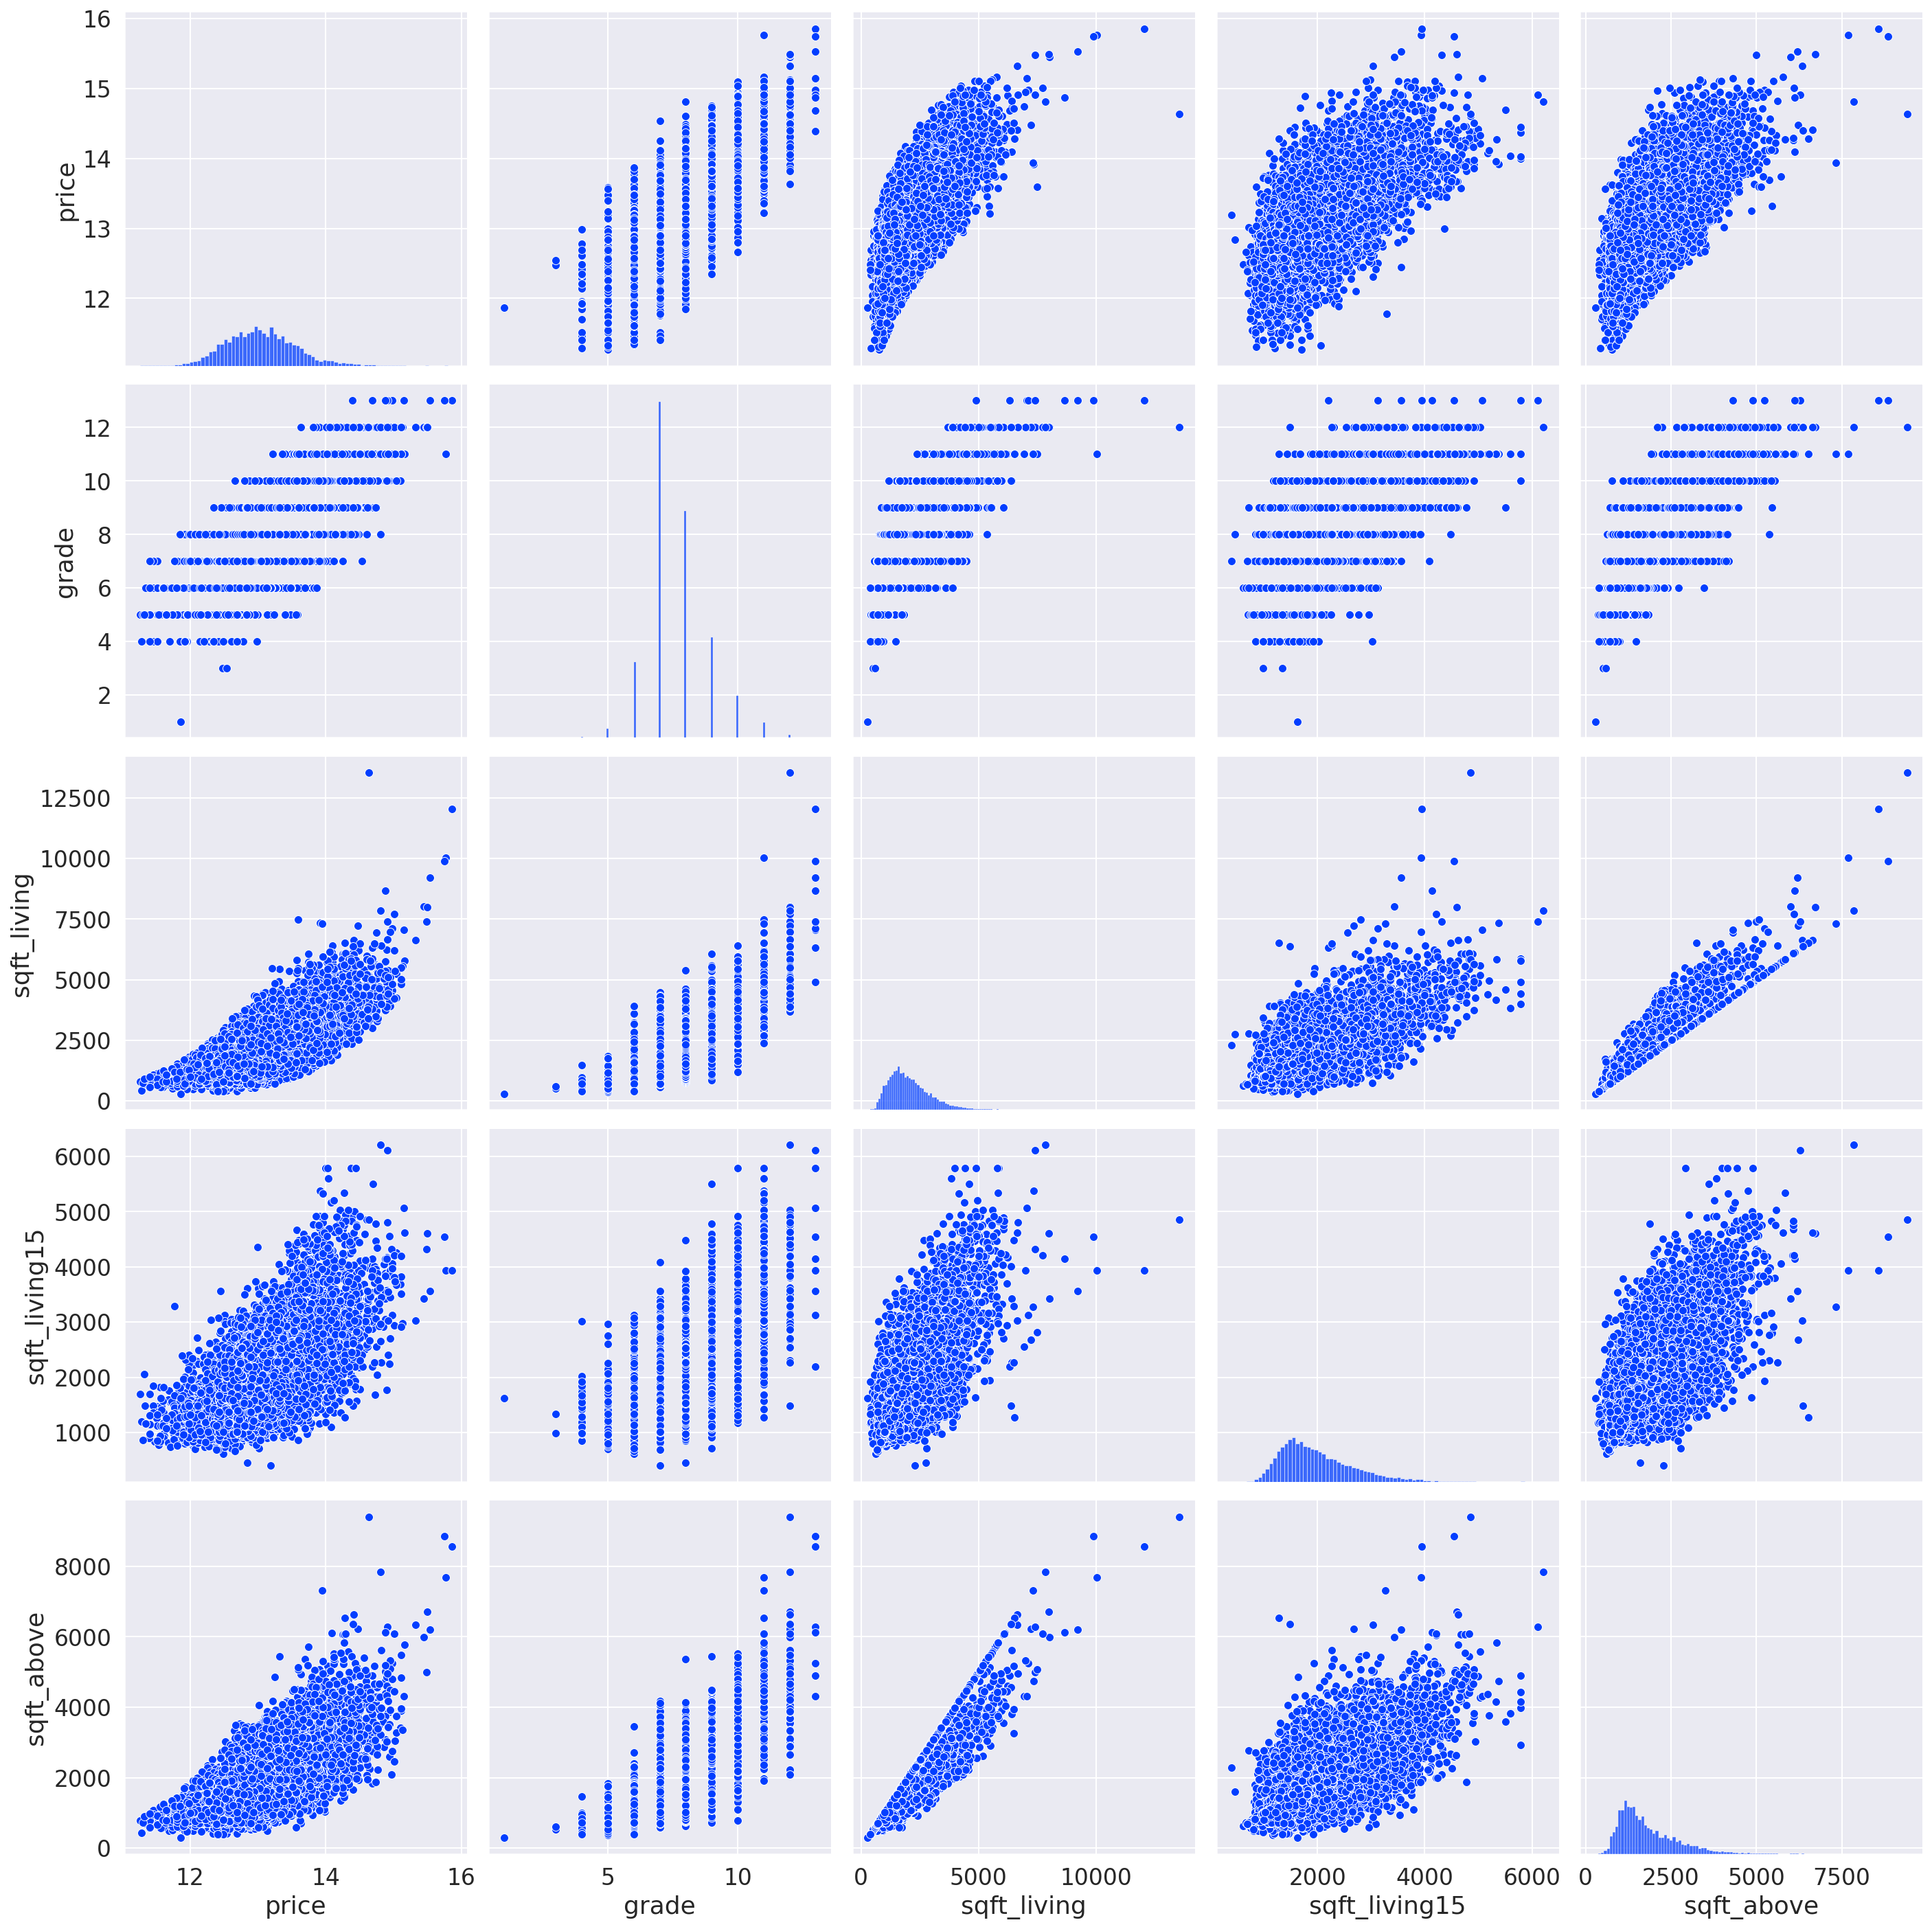

In [ ]:
plt.style.use('dark_background') 
sns.set(style="darkgrid",palette="bright", font_scale=1.5) 
sns.pairplot(df_train[['price','grade','sqft_living', 'sqft_living15', 'sqft_above']], height=4)

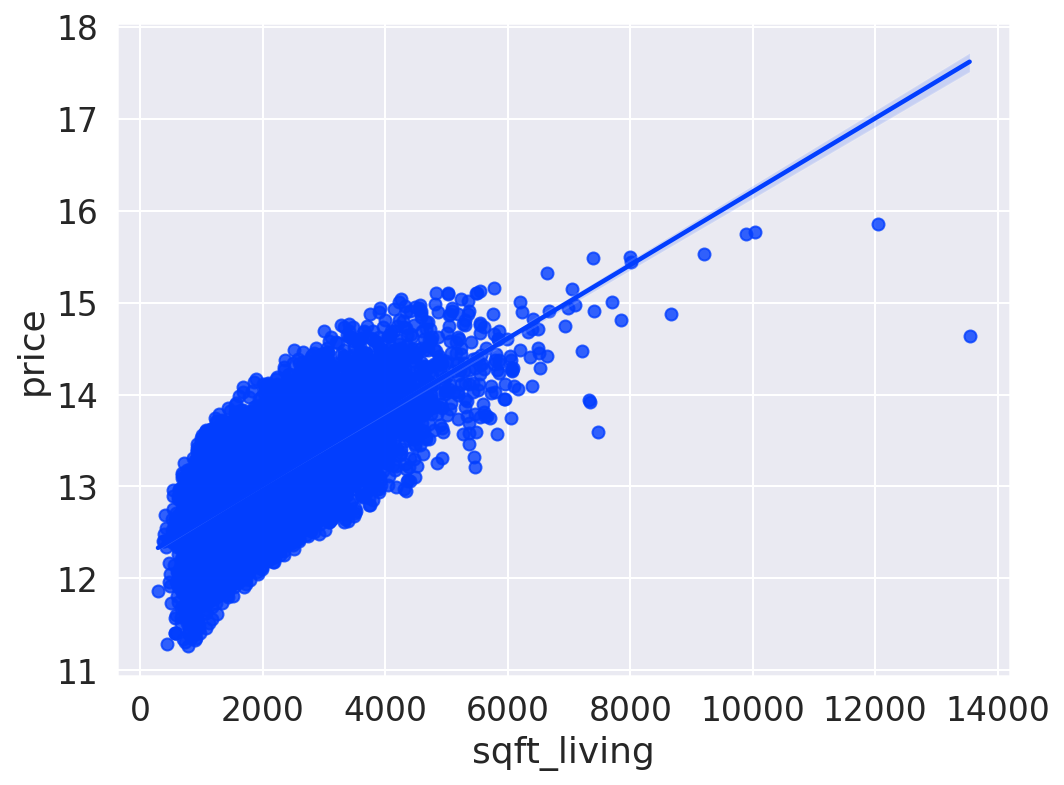

In [ ]:
data = pd.concat([df_train['price'], df_train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y="price", data=data)

In [ ]:
#outlier 제거
df_train.loc[df_train['sqft_living'] > 13000]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8912,8912,20140505T000000,14.639686,7,8.0,13540,307752,3.0,0,4,3,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


###  5.학습 데이터와 테스트 데이터 합치기

In [ ]:
train_len = len(data)
data = pd.concat((data, sub), axis=0)

print(len(data))

21503


In [ ]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### 6.전처리

In [ ]:
data.isnull().sum()

id               0
date             0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [ ]:
import scipy as sp

cor_abs = abs(df_train.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=10, columns='price').index # price과 correlation이 높은 column 10개 뽑기(내림차순)
# spearman coefficient matrix
cor = np.array(sp.stats.spearmanr(df_train[cor_cols].values))[0] # 10 x 10
print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values)

### 7. id, date 변수 정리

In [ ]:
sub_id = data['id'][train_len:]
del data['id']

print(data.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [ ]:
data['date'] = data['date'].apply(lambda x : str(x[:6]))#연/월 데이터만

data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### 8. 각 변수들 분포 확인

bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement, sqft_living15, sqft_lot15 변수가 한쪽으로 치우친 경향을 보이는군요.




In [ ]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

얍💢


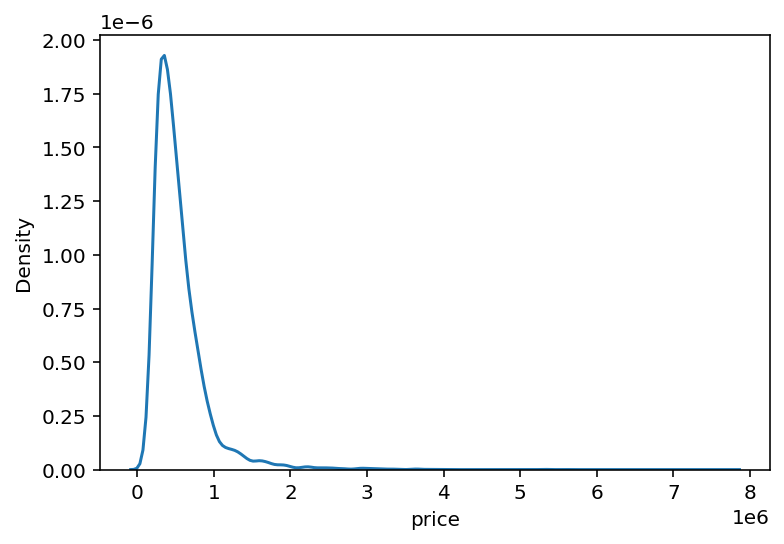

In [ ]:
sns.kdeplot(y)
plt.show()

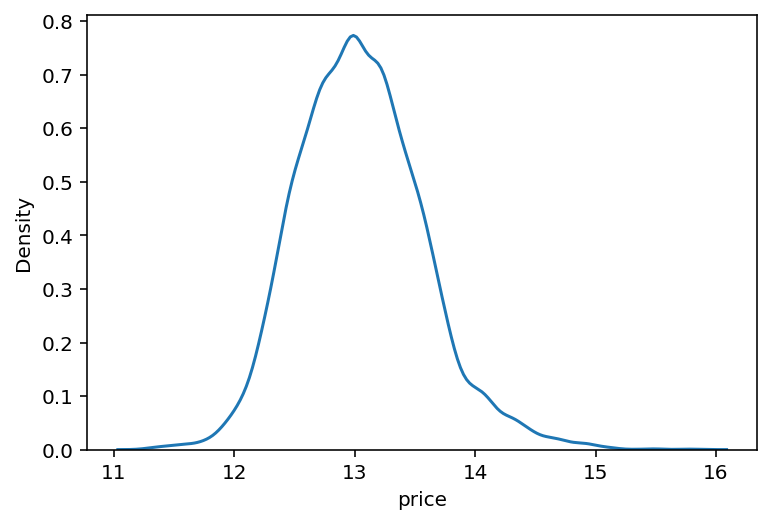

In [ ]:
y_log_transformation = np.log1p(y)

sns.kdeplot(y_log_transformation)
plt.show()

In [ ]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

print(x.shape)
print(sub.shape)

(15035, 19)
(6468, 19)


### Feature Engineering

In [ ]:
train

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,201410,4,2.50,2520,6023,2.0,0,0,3,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,201503,4,3.50,3510,7200,2.0,0,0,3,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,201405,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,201502,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200


In [ ]:
data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,1.386294,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.0,1955,0,98178,47.5112,-122.257,7.201171,8.639588
1,201502,1.098612,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.0,1933,0,98028,47.7379,-122.233,7.908755,8.995041
2,201502,1.386294,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.0,1987,0,98074,47.6168,-122.045,7.496097,8.923191
3,201406,1.386294,2.25,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.0,1995,0,98003,47.3097,-122.327,7.713785,8.827615
4,201501,1.386294,1.50,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.0,1963,0,98198,47.4095,-122.315,7.409136,9.181118


###9. Average Blending

In [ ]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

### 10.Cross Validation

In [ ]:
def get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=2019).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")

In [ ]:
get_cv_score(models)

Model: GradientBoosting, CV score:0.8598
[07:18:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:18:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:18:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:18:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:18:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Model: XGBoost, CV score:0.8624
Model: LightGBM, CV score:0.8819


11 .Make Submission File

In [ ]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

print('얍💢')

얍💢


In [ ]:
y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred))
y_pred

[07:18:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
6468


array([ 562566.39221578,  389660.68147617, 1340643.45409443, ...,
        438058.69137012,  345498.01852609,  414241.23776683])

In [ ]:
data_dir = '/content/drive/MyDrive/Github/Kaggle/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [ ]:
result = pd.DataFrame({
    'id' : sub_id, 
    'price' : y_pred
})

result.head()

,id,price
0,15035,5.625664e+05
1,15036,3.896607e+05
2,15037,1.340643e+06
3,15038,3.317573e+05
4,15039,2.966855e+05


In [ ]:
my_submission_path = join(data_dir, 'submission.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)

/content/drive/MyDrive/Github/Kaggle/kaggle_kakr_housing/data/submission.csv


# 새롭게 도전!

In [ ]:
data_dir = '/content/drive/MyDrive/Github/Kaggle/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [ ]:
#date 수정
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
#test도
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [ ]:
#target분리
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [ ]:
#id 제거
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [ ]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

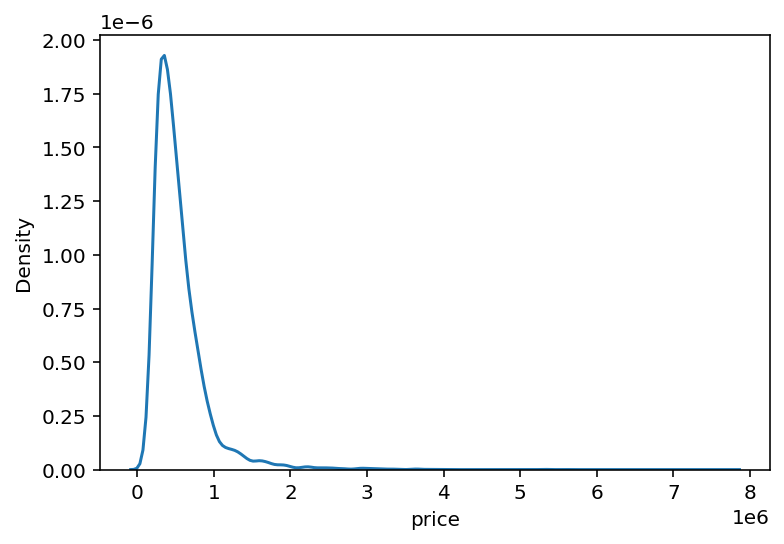

In [ ]:
sns.kdeplot(y)
plt.show()

In [ ]:
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

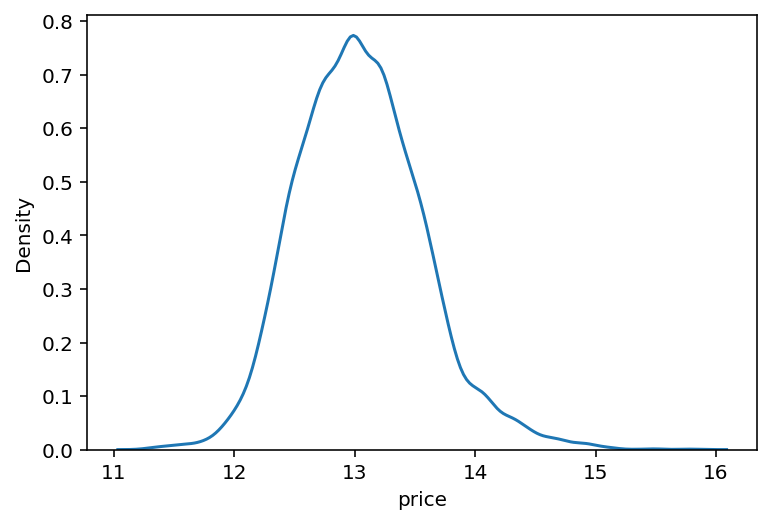

In [ ]:
sns.kdeplot(y)
plt.show()

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

한 가지 주의해야 할 것은, y_test나 y_pred는 위에서 np.log1p()로 변환이 된 값이기 때문에 원래 데이터의 단위에 맞게 되돌리기 위해 np.expm1()을 추가해야 한다는 점입니다.

In [ ]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [ ]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]


In [ ]:
gboost.__class__.__name__ #모델의 이름 얻기

'GradientBoostingRegressor'

In [ ]:
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

[07:18:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


{'GradientBoostingRegressor': 128360.19649691365,
 'LGBMRegressor': 111920.36735892233,
 'RandomForestRegressor': 125576.03932336495,
 'XGBRegressor': 131067.44622809246}

In [ ]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

In [ ]:
from sklearn.model_selection import GridSearchCV

우선 그리드 탐색과 랜덤 탐색을 알아볼 필요가 있습니다. 두 가지 모두 하이퍼 파라미터를 조합해 보는 방법입니다.

그리드 탐색은 사람이 먼저 탐색할 하이퍼 파라미터의 값들을 정해두고, 그 값들로 만들어질 수 있는 모든 조합을 탐색합니다. 특정 값에 대한 하이퍼 파라미터 조합을 모두 탐색하고자 할 때 유리


랜덤 탐색은 사람이 탐색할 하이퍼 파라미터의 공간만 정해두고, 그 안에서 랜덤으로 조합을 선택해서 탐색하는 방법입니다.

param_grid : 탐색할 파라미터의 종류 (딕셔너리로 입력)

scoring : 모델의 성능을 평가할 지표

cv : cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 개수

verbose : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양 (숫자가 클수록 더 많은 메세지를 출력합니다.)

n_jobs : 그리드 탐색을 진행하면서 사용할 CPU의 개수

In [ ]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}#가능한 조합은 총 2x2 = 4가지 
#cross validation은 경우마다 5번 진행 -> 4x5 = 20 fits진행

In [ ]:
model = LGBMRegressor(random_state=random_state)

grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    7.2s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=2020,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='deprecated', n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_s

In [ ]:
grid_model.cv_results_ #grid_model.fit 함수를 통해서 4가지 조합에 대한 실험 결과

{'mean_fit_time': array([0.34236956, 0.39309068, 1.00696011, 1.58746781]),
 'mean_score_time': array([0.0257781 , 0.03058152, 0.04600477, 0.0611073 ]),
 'mean_test_score': array([-0.07339447, -0.05502043, -0.02917734, -0.02702714]),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1, 'n_estimators': 50},
  {'max_depth': 1, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 10, 'n_estimators': 100}],
 'rank_test_score': array([4, 3, 2, 1], dtype=int32),
 'split0_test_score': array([-0.0756974 , -0.05555652, -0.02885847, -0.02665428]),
 'split1_test_score': array([-0.07666447, -0.057876  , -0.03041465, -0.02795896]),
 'split2_test_score': array([-0.07354904, -0.05546079, 

In [ ]:
params = grid_model.cv_results_['params']
params

[{'max_depth': 1, 'n_estimators': 50},
 {'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 50},
 {'max_depth': 10, 'n_estimators': 100}]

In [ ]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.07339447, -0.05502043, -0.02917734, -0.02702714])

In [ ]:
results = pd.DataFrame(params)
results['score'] = score

results
#왜 스코어값이 음수? 
#GridSearchCV에서 모델을 초기화할 때 scoring 인자에 MSE에 음수를 취한 값인 neg_mean_squared_error가 들어감

,max_depth,n_estimators,score
0,1,50,-0.073394
1,1,100,-0.055020
2,10,50,-0.029177
3,10,100,-0.027027


In [ ]:
results['RMSE'] = np.sqrt(-1 * results['score'])#음수로 된 MSE였으니, -1을 곱해주고 np.sqrt로 루트 연산
results

,max_depth,n_estimators,score,RMSE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


In [ ]:
results = results.rename(columns={'RMSE': 'RMSLE'})#사실상 Root Mean Squared Log Error임
results

,max_depth,n_estimators,score,RMSLE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


In [ ]:
results = results.sort_values('RMSLE')
results

,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


In [ ]:
"""
다음과 같은 과정을 진행할 수 있는 `my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)` 함수를 구현해 보세요.

1. GridSearchCV 모델로 `model`을 초기화합니다.
2. 모델을 fitting 합니다.
3. params, score에 각 조합에 대한 결과를 저장합니다. 
4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환합니다.
"""

def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [ ]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    3.6s finished


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


In [ ]:
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

ValueError: ignored

In [ ]:
"""
아래의 과정을 수행하는 `save_submission(model, train, y, test, model_name, rmsle)` 함수를 구현해 주세요.
1. 모델을 `train`, `y`로 학습시킵니다.
2. `test`에 대해 예측합니다.
3. 예측값을 `np.expm1`으로 변환하고, `submission_model_name_RMSLE_100000.csv` 형태의 `csv` 파일을 저장합니다.
"""

def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = '/content/drive/MyDrive/Github/Kaggle/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [ ]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.0168')